In [1]:
using Plots
using CombinatorialSpaces

In [2]:
time_steps = 1000
width = 10
height = 10
num_oscillators = width*height

k = 5
dt = 0.1
dx0 = 1.5
dy0 = 1.5
dxm = dx0
visc = -0.1
m = range(1, stop=1, length=num_oscillators)
g = 0.1

s = OrientedDeltaSet2D{Bool}()
add_vertices!(s, num_oscillators)

ind(x,y) = x + (y-1)*(width)

for y in 1:(height-1)
    for x in 1:(width-1)
        #if (x <= 2 || x >= width - 2) || (y <= 2 || y >= height - 2)
            glue_sorted_triangle!(s, ind(x,y), ind(x+1,y), ind(x,y+1), tri_orientation=true)
            glue_sorted_triangle!(s, ind(x+1,y+1), ind(x+1,y), ind(x,y+1), tri_orientation=false)
            glue_sorted_triangle!(s, ind(x+1,y), ind(x+1,y+1), ind(x,y), tri_orientation=true)
            glue_sorted_triangle!(s, ind(x,y+1), ind(x+1,y+1), ind(x,y), tri_orientation=false)
        #end
    end
end

In [3]:
mag(x) = sqrt(x[1]^2+x[2]^2)
unit(x) = x ./ mag(x)

cobound = d(0, s)
bound = boundary(1,s)
# Coboundary operator from 0-simplex to 1-simplex in primal complex
x_to_Δx!(dx, x) = begin
    for i in 1:size(x)[1]
        view(dx,i,:) .= cobound*view(x,i,:)
    end
end

# Constitutive equation from primal to dual complex
Δx_to_f!(f, dx) = begin
    for i in 1:size(dx)[2]
        view(f,:,i) .= k * (view(dx,:,i) .- dxm * unit(view(dx,:,i)))
    end
end

# Coboundary operator from 0-simplex to 1-simplex in dual complex
f_to_∑f!(sf, f) = begin
    for i in 1:size(f)[1]
        view(sf,i,:) .= bound*view(f,i,:) .* -1
    end
end

# Solved coboundary (?) operator from 1-simplex to 0-simplex in dual temporal complex
∑f_to_p!(p, p0, sf) = begin
    p .= p0 .+ sf * dt
end

# Constitutive equation from dual to primal complex
p_to_v!(v, p) = begin
    v .= p ./ hcat(m,m)'
end

# Solved coboundary (?) operator from 1-simplex to 0-simplex in dual temporal complex
v_to_x!(x, x0, v) = begin
    x .= x0 .+ v * dt
end
v_to_∑f!(sf, v) = begin
    sf .+= visc * v
end

g_to_∑f!(sf) = begin
    for i in 1:size(sf)[2]
        view(sf,:,i) .+= [0.0, -g] .* m[i]
    end
end

g_to_∑f! (generic function with 1 method)

In [4]:

values = Dict{Symbol, Array{Float64, 3}}()

# Initialize harmonic oscillators
values[:IP] =  zeros(Float64,2,nv(s), time_steps+1)  # x
values[:TP] =  zeros(Float64,2,nv(s), time_steps+1)  # v
values[:IL] =  zeros(Float64,2,ne(s), time_steps+1)  # Δx
values[:TP2] = zeros(Float64,2,ne(s), time_steps)    # f
values[:TL2] = zeros(Float64,2,nv(s), time_steps)    # ∑f
values[:IL2] = zeros(Float64,2,nv(s), time_steps+1)  # p

# Initial conditions
for y in 1:height
    for x in 1:width
        values[:IP][:, ind(x,y),1] = [(x-1)*dx0, (y-1)*dy0]
    end
end
for i in 1:time_steps
    x_to_Δx!(view(values[:IL],:, :, i), values[:IP][:,:, i])
    Δx_to_f!(view(values[:TP2],:, :, i), values[:IL][:,:, i])
    f_to_∑f!(view(values[:TL2],:, :, i), values[:TP2][:,:, i])
    v_to_∑f!(view(values[:TL2],:, :, i), values[:TP][:,:, i])
    g_to_∑f!(view(values[:TL2],:, :, i))
    ∑f_to_p!(view(values[:IL2],:, :, i+1), values[:IL2][:,:, i], values[:TL2][:,:, i])
    p_to_v!(view(values[:TP],:, :, i+1), values[:IL2][:,:, i+1])
    v_to_x!(view(values[:IP],:, :, i+1), values[:IP][:,:, i], values[:TP][:,:, i+1])
    #==
    for x in 1:width
        values[:IP][x, i+1] = (dx0*(x-1),0) # Enforced boundary condition
    end==#
    for x in 1:nv(s)
        tmp_val = values[:IP][:,x, i+1]
        if(tmp_val[2] < -20)
            values[:IP][:,x, i+1] .= [tmp_val[1],-20]
            values[:IL2][:,x, i+1] .= [values[:IL2][1,x, i+1], 0]
            values[:TP][:,x, i+1] .= [values[:TP][1,x, i+1], 0]
        end
         # Enforced boundary condition
    end
end


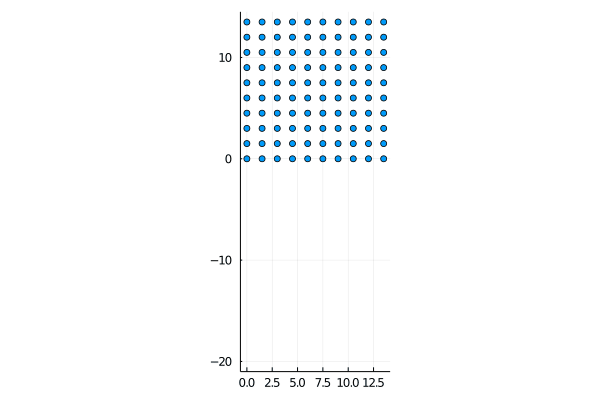

In [5]:
anim = @animate for i ∈ 1:5:(time_steps)
    plot(values[:IP][1,:,i],values[:IP][2,:,i], legend=:none, seriestype = :scatter, ylims=[minimum(values[:IP][2,:,:]),maximum(values[:IP][2,:,:])], xlims=[minimum(values[:IP][1,:,:]), maximum(values[:IP][1,:,:])], ratio=1)
end
gif(anim, fps = 30)